# Project 5: Random Forest

Replicate figure 15.3 comparing random forests and gradient boosted trees. You can use whatever package you wish, you don't have to use xgboost if you'd rather keep everything in sci-kit learn. Compare the feature importance found by random forests and gradient boosted trees. If there are significant differences, can you offer an explanation? 



Select another dataset and repeat the analysis. Pick a dataset we have not yet studied in class.

In [38]:
from sklearn.datasets import fetch_california_housing
from xgboost import XGBRegressor, XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import pandas as pd
import shap
import numpy as np
from tqdm import tqdm
shap.initjs()

In [3]:
data, target = shap.datasets.california()

In [4]:
X = data
y = target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
rf2_maes = []
rf4_maes = []
gb4_maes = []
gb6_maes = []

n_estimators_list = [1, 10, 20, 50, 100, 200, 500, 1000] # takes too long to increment by 1 >:(

for n in tqdm(n_estimators_list):
    rf2 = RandomForestRegressor(n_estimators=n, max_features=2, random_state=42)
    rf6 = RandomForestRegressor(n_estimators=n, max_features=6, random_state=42)
    gb4 = XGBRegressor(n_estimators=n, max_depth=4, learning_rate=0.05, random_state=42)
    gb6 = XGBRegressor(n_estimators=n, max_depth=6, learning_rate=0.05, random_state=42)

    rf2.fit(X_train, y_train)
    rf6.fit(X_train, y_train)
    gb4.fit(X_train, y_train)
    gb6.fit(X_train, y_train)

    rf2_pred = rf2.predict(X_test)
    rf6_pred = rf6.predict(X_test)
    gb4_pred = gb4.predict(X_test)
    gb6_pred = gb6.predict(X_test)


    rf2_mae = mean_absolute_error(y_test, rf2_pred)
    rf6_mae = mean_absolute_error(y_test, rf6_pred)
    gb4_mae = mean_absolute_error(y_test, gb4_pred)
    gb6_mae = mean_absolute_error(y_test, gb6_pred)

    
    rf2_maes.append(rf2_mae)
    rf4_maes.append(rf6_mae)
    gb4_maes.append(gb4_mae)
    gb6_maes.append(gb6_mae)


100%|██████████| 8/8 [03:14<00:00, 24.34s/it]


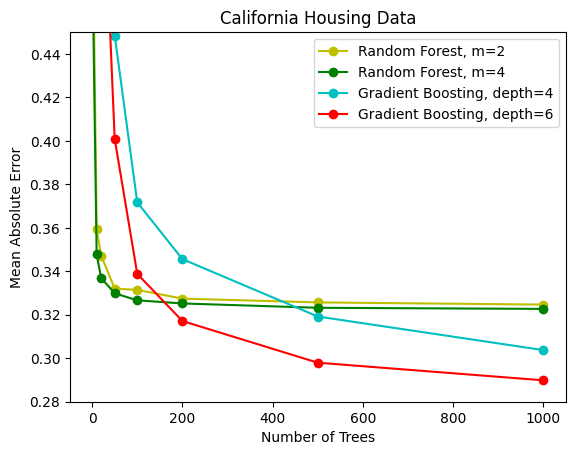

In [32]:
plt.plot(n_estimators_list, rf2_maes, 'oy-', label='Random Forest, m=2')
plt.plot(n_estimators_list, rf4_maes, 'og-', label='Random Forest, m=4')
plt.plot(n_estimators_list, gb4_maes, 'oc-', label='Gradient Boosting, depth=4')
plt.plot(n_estimators_list, gb6_maes, 'or-', label='Gradient Boosting, depth=6')

plt.xlabel('Number of Trees')
plt.ylabel('Mean Absolute Error')

plt.ylim(0.28, 0.45)

plt.title('California Housing Data')
plt.legend()
plt.show()

In [42]:
features = data.columns
gb4_importances = gb4.feature_importances_
gb6_importances = gb6.feature_importances_
rf2_importances = rf2.feature_importances_
rf6_importances = rf6.feature_importances_


Text(0.5, 0, 'Feature Importance')

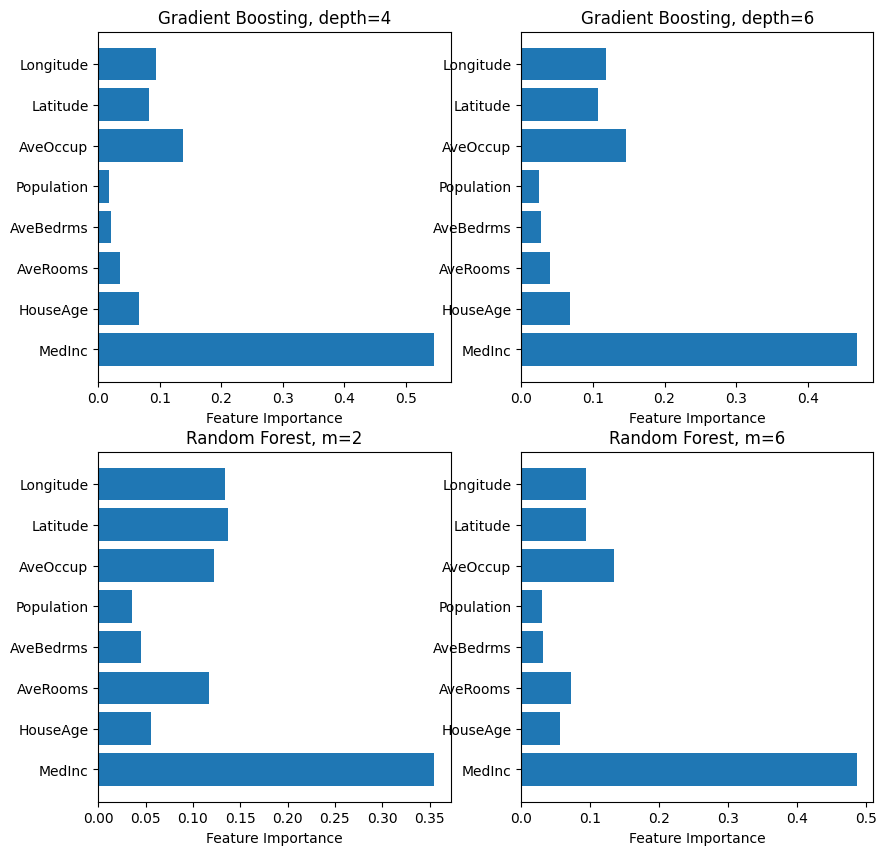

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

ax[0, 0].barh(features, gb4_importances)
ax[0, 0].set_title('Gradient Boosting, depth=4')
ax[0, 0].set_xlabel('Feature Importance')

ax[0, 1].barh(features, gb6_importances)
ax[0, 1].set_title('Gradient Boosting, depth=6')
ax[0, 1].set_xlabel('Feature Importance')

ax[1, 0].barh(features, rf2_importances)
ax[1, 0].set_title('Random Forest, m=2')
ax[1, 0].set_xlabel('Feature Importance')

ax[1, 1].barh(features, rf6_importances)
ax[1, 1].set_title('Random Forest, m=6')
ax[1, 1].set_xlabel('Feature Importance')

Medium Income is the most important feature in all four models. In gb4, gb6, and rf6, the Average Occupancy feature is the second most important feature, while rf2 has latitude as its second highest. However, all four have longitude, latitude, and average occupancy bunched up in generally the same importance value. 

For the gradient boosted models, there is a trend where the least important features are in this order: population, average bedrooms, average rooms, and house age. Instead in the random forest models, the order is population, average bedrooms, house age, and average rooms. This distinct pattern is perhaps caused by the different architectures between the two types of models.

## New Dataset: Beer Consumption :D

https://www.kaggle.com/datasets/dongeorge/beer-consumption-sao-paulo \
"Beer is one of the most democratic and consumed drinks in the world. Not without reason, it is perfect for almost every situation, from happy hour to large wedding parties. If you just think about it, you already feel like having a beer, you’re not alone.
The truth is that around the world, thousands of people consume the drink regularly and also in different situations. But have you ever stopped to think about which countries are the most consuming beer in the world? The first one that came to your head was Germany? Well, know that it is not so.
The answer to that question is resounding: the Czech Republic. According to research by the Japanese beverage company Kirin, the country has topped the per capita beer drinking table for 23 consecutive years.
In 2015, the most recent year for which statistics are available, the Czechs drank 142.4 litres per person. That’s the equivalent of 250 pints — or one every 35 hours. But, given that minors are unlikely to be contributing to that figure, it’s safe to assume that the average beer drinker probably guzzles quite a bit more.
Snapping at the Czech Republic’s heels are the usual pretenders. Austria and Germany come third and fourth, Poland sixth and Ireland seventh.There are some surprises, however. In second place is the Seychelles, a lofty ranking which we’ll put down to the hot climate and the large number of holidaymakers.

The data (sample) were collected in São Paulo — Brazil, in a university area, where there are some parties with groups of students from 18 to 28 years of age (average). The dataset used for this activity has 7 attributes, being a Target, with period of one year."

In [ ]:
beer_df = pd.read_csv('Consumo_cerveja.csv')
beer_df.dropna(inplace=True)
beer_df.drop('Data', axis=1, inplace=True)

# data had numbers with commas instead of periods for decimals
beer_df.replace(',', '.', regex=True, inplace=True)

#  convert to numeric
for column in beer_df.columns:
    if beer_df[column].dtype != 'float64': 
        beer_df[column] = pd.to_numeric(beer_df[column], errors='coerce')

# standardize data
beer_df = (beer_df - beer_df.mean()) / beer_df.std()

y = beer_df.pop('Consumo de cerveja (litros)')  # "Beer Consumption (L)" in Portuguese
X = beer_df

In [73]:
X.head()

,Temperatura Media (C),Temperatura Minima (C),Temperatura Maxima (C),Precipitacao (mm),Final de Semana
0,1.909886,2.278205,1.363909,-0.418487,-0.630377
1,1.821839,2.490506,1.595532,-0.418487,-0.630377
2,1.130038,1.747455,0.761690,-0.418487,1.582005
3,0.865896,1.429004,0.460580,-0.321852,1.582005
4,0.815584,1.252087,0.391093,-0.418487,-0.630377


In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [75]:
rf2_maes = []
rf4_maes = []
gb4_maes = []
gb6_maes = []

n_estimators_list = [1, 10, 20, 50, 100, 200, 500, 1000] # takes too long to increment by 1 >:(

for n in tqdm(n_estimators_list):
    rf2 = RandomForestRegressor(n_estimators=n, max_features=2, random_state=42)
    rf6 = RandomForestRegressor(n_estimators=n, max_features=6, random_state=42)
    gb4 = XGBRegressor(n_estimators=n, max_depth=4, learning_rate=0.05, random_state=42)
    gb6 = XGBRegressor(n_estimators=n, max_depth=6, learning_rate=0.05, random_state=42)

    rf2.fit(X_train, y_train)
    rf6.fit(X_train, y_train)
    gb4.fit(X_train, y_train)
    gb6.fit(X_train, y_train)

    rf2_pred = rf2.predict(X_test)
    rf6_pred = rf6.predict(X_test)
    gb4_pred = gb4.predict(X_test)
    gb6_pred = gb6.predict(X_test)


    rf2_mae = mean_absolute_error(y_test, rf2_pred)
    rf6_mae = mean_absolute_error(y_test, rf6_pred)
    gb4_mae = mean_absolute_error(y_test, gb4_pred)
    gb6_mae = mean_absolute_error(y_test, gb6_pred)

    
    rf2_maes.append(rf2_mae)
    rf4_maes.append(rf6_mae)
    gb4_maes.append(gb4_mae)
    gb6_maes.append(gb6_mae)


  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:04<00:00,  1.69it/s]


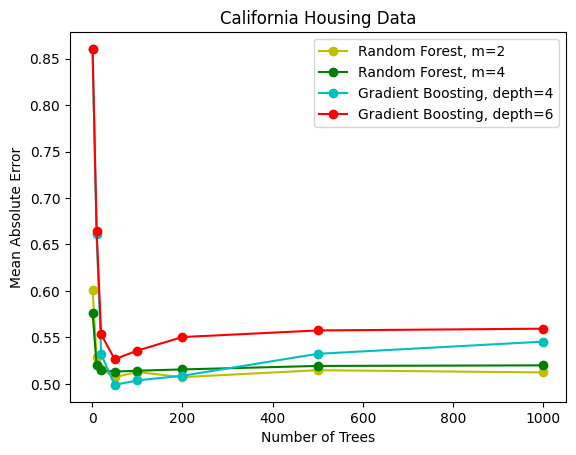

In [76]:
plt.plot(n_estimators_list, rf2_maes, 'oy-', label='Random Forest, m=2')
plt.plot(n_estimators_list, rf4_maes, 'og-', label='Random Forest, m=4')
plt.plot(n_estimators_list, gb4_maes, 'oc-', label='Gradient Boosting, depth=4')
plt.plot(n_estimators_list, gb6_maes, 'or-', label='Gradient Boosting, depth=6')

plt.xlabel('Number of Trees')
plt.ylabel('Mean Absolute Error')

# plt.ylim(0.28, 0.45)

plt.title('California Housing Data')
plt.legend()
plt.show()

In [85]:
# translate features to english
features = ['Medium Temperature (C)', 'Minimum Temperature (C)', 'Maximum Temperature (C)', 'Precipitation (mm)', 'Weekend']
gb4_importances = gb4.feature_importances_
gb6_importances = gb6.feature_importances_
rf2_importances = rf2.feature_importances_
rf6_importances = rf6.feature_importances_


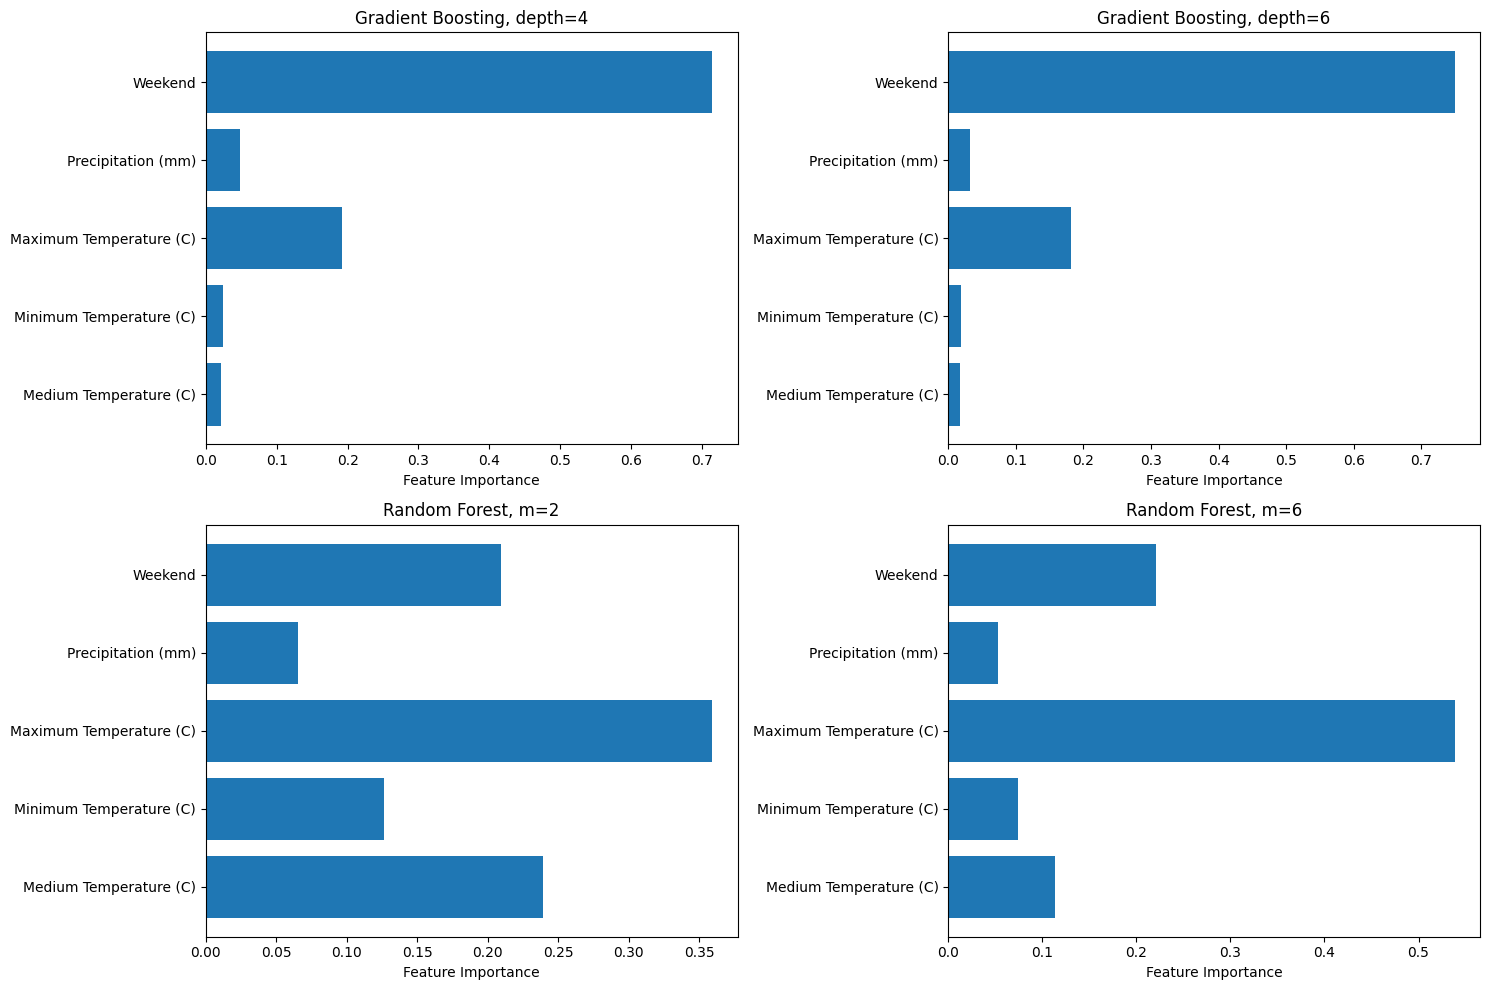

In [86]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

ax[0, 0].barh(features, gb4_importances)
ax[0, 0].set_title('Gradient Boosting, depth=4')
ax[0, 0].set_xlabel('Feature Importance')

ax[0, 1].barh(features, gb6_importances)
ax[0, 1].set_title('Gradient Boosting, depth=6')
ax[0, 1].set_xlabel('Feature Importance')

ax[1, 0].barh(features, rf2_importances)
ax[1, 0].set_title('Random Forest, m=2')
ax[1, 0].set_xlabel('Feature Importance')

ax[1, 1].barh(features, rf6_importances)
ax[1, 1].set_title('Random Forest, m=6')
ax[1, 1].set_xlabel('Feature Importance')

plt.tight_layout()

interesting! In the gradient boosted models, being a weekend holds a much greater impact than in the random forest models. In contrast, the maximum temperature of the day each datapoint was recorded is the most important feature. I would trust the gradient boosted models more because intuitively, more college students would drink beer on the weekends. I do not believe that temperature would have that much of an impact on how much beer is consumed.